In [112]:
import numpy as np
import math
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from matplotlib.patches import Circle
from mpl_toolkits.mplot3d import Axes3D
import time

# Use %matplotlib notebook to change to a zoom-able display.
%matplotlib inline

### earth3D

Function to create and plot a 3D earth

In [113]:
def earth3D(rad):
    '''
    rad is in earth radii [RE]
    
    '''
    ns     = 100 # numbner samples
    stride = 1

    # phi; goes from [0:2*PI]
    phi = np.linspace(0.,2.*np.pi,ns)

    # theta; goes from [0:PI]
    tht = np.linspace(0.,np.pi,ns)

    x = rad*np.outer(np.cos(phi), np.sin(tht))
    y = rad*np.outer(np.sin(phi), np.sin(tht))
    z = rad*np.outer(np.ones(np.size(phi)), np.cos(tht))

    ax.plot_surface(x, y, z, linewidth=0.0, cstride=stride, rstride=stride, color = 'b')
    


### 3D Dipole 1 - based on Garcia-Farieta (2019)

The working model, using the dipole field in terms of magnetic dipole moment $|\vec{m}|=7.79 \times 10^{22} \mathrm{Am}^{2}$, 

$$\vec{B}=\frac{\mu_{0}}{4 \pi r^{3}}[3(\vec{m} \cdot \hat{r}) \hat{r}-\vec{m}]$$

In [114]:
phi = np.radians(11.7)                                  # tilt of magnetic axis [rad]
mu = -7.94e22*np.array([.0, np.sin(phi), np.cos(phi)])  # magnetic moment of earth [A*m^2]
M0 = 1.0e-7                                             # mu_0/4*PI
RE = 6371000                                            # radius of earth [m]

def B(R, mu):
    r = R*RE
    rmag = np.sqrt(np.dot(r, r))
    Bfield = M0*(3.*r*np.dot(mu,r)/(rmag**5)-mu/(rmag**3))
    return Bfield 

### 3D Dipole 2 - mine

The broken model, using the dipole field in terms of cartesian coordinates, 

$$\mathbf{B}(\mathbf{r})=B_{0} R_{E}^{3}\left(\frac{1}{r^{5}}\right)\left[-3 x z \hat{\mathbf{x}}-3 y z \hat{\mathbf{y}}+\left(r^{2}-3 z^{2}\right) \hat{\mathbf{z}}\right]$$

In [137]:
from scipy.spatial.transform import Rotation as R

def Bdip(coords):
    
    RE = 6371000           # radius of earth [m]
    BE = 3.12e-5           # mag. field strength at surface of earth [T]
    
    coords = coords*RE
    
    Bdip = np.zeros(3)
    
    x = coords[0]
    y = coords[1]
    z = coords[2]
    r = np.sqrt(np.dot(coords,coords))
    
    c0 = (BE*RE**3.0)/r**5.0
    
    Bdip[0] = c0*(-3.0*x*z)          # Bx
    Bdip[1] = c0*(-3.0*y*z)          # By
    Bdip[2] = c0*(r**2.0-3.0*z**2.0) # Bz

    return Bdip




## Main
Computes motion of an electric charge in a magnetic dipole field using Boris particle pushing method.

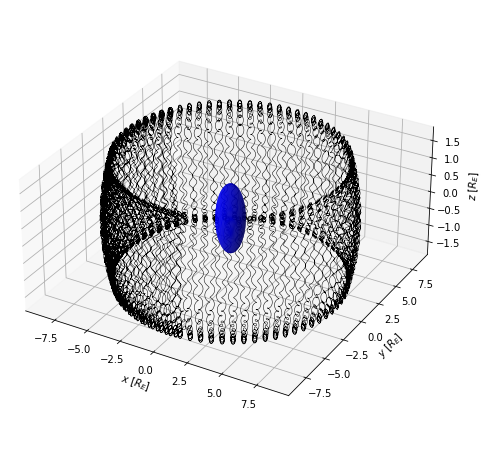

runtime = 19.601980924606323 s (0.3266996820767721 min)


In [138]:
# start time
time_start = time.time()

mp = 1.6e-27           # proton mass [kg]
me = 9.1e-31           # electron mass [kg]
qe = 1.603E-19         # proton charge [C]

dt = 0.01
tf = 6000
steps = int(tf/dt)

tdat = np.zeros(steps)
rdat = np.zeros((steps,3))
vdat =  np.zeros((steps,3))

# creating charged particle
m = 4.*mp
q = 2.*qe


# set initial conditions
rdat[0] = np.array([1., -7.85, -1.53])
vdat[0] = np.array([0.,.3,.3])

'''
# sample conditions for ref.

rdat[0] = np.array([1., -7.85, -1.53])
vdat[0] = np.array([0.,.3,.3])

'''


for i in range(0, steps-1):
    
        r = rdat[i]
        v = vdat[i]
        
        tdat[i] = i*dt

        #B0 = B(r, mu)
        B0 = Bdip(r) # my version
    
        E = 0
        c0 = (dt*q*B0)/(2*m)
        
        # push step 1 - update velocity with half electrostatic contribution
        v1 = v + (q*E*dt)/(2*m)
        
        # push step 2 - rotated via the magnetic field contribution 
        ax = v1 + np.cross(v1,c0)
        bx = (2*c0)/(1+c0**2)
        v2 = v1 + np.cross(ax,bx)
        
        # push step 3 - updated again with another half of the electrostatic push
        vnew = v2 + (q*E*dt)/(2*m)
        
        # update position
        rnew = r + vnew*dt
        
        # append to data arrays
        vdat[i+1] = vnew
        rdat[i+1] = rnew


fig = plt.figure(figsize=(8, 8))
ax = plt.axes(projection='3d')

# plot dipole field data
ax.plot3D(rdat[:,0],rdat[:,1],rdat[:,2],'k',linewidth=0.5)

# plot 3D earth
earth3D(1)

# plot attributes
ax.set_box_aspect([1,1,.5])
ax.set_xlabel("$x$ [$R_E$]")
ax.set_ylabel("$y$ [$R_E$]")
ax.set_zlabel("$z$ [$R_E$]")

plt.show()

# end time
time_end = time.time()

# print runtime
runtime = time_end - time_start
print(f"runtime = {runtime} s ({runtime/60} min)")

Text(108.125, 0.5, '$v_z$ [$m/s$]')

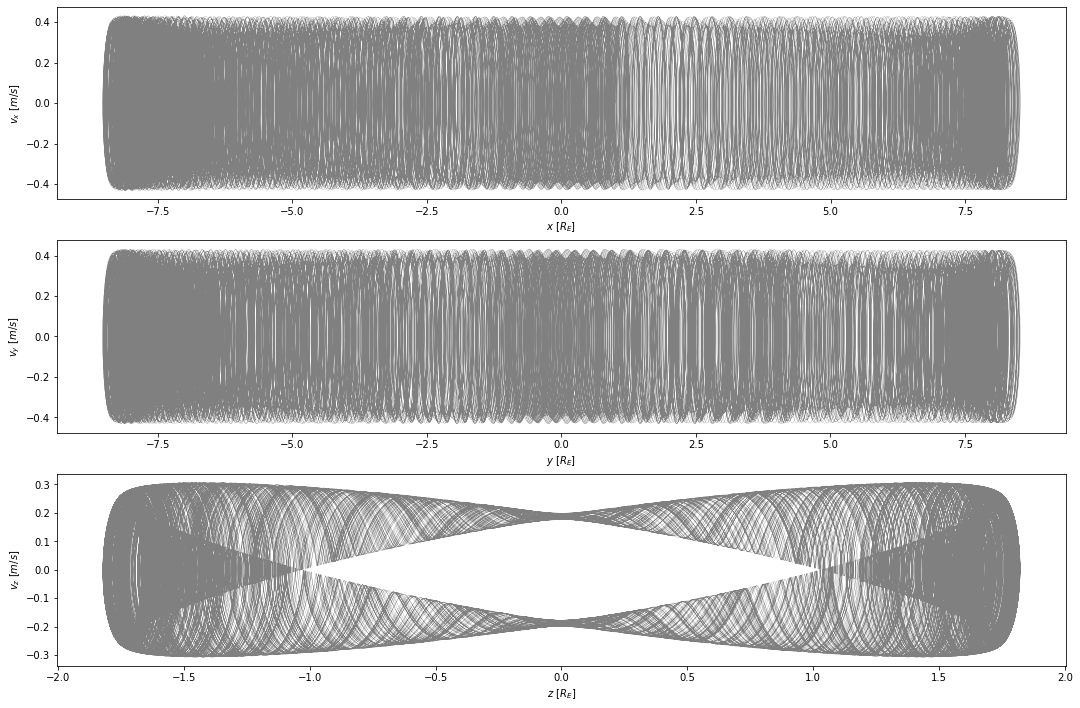

In [139]:
fig, (ax1, ax2, ax3) = plt.subplots(3, figsize=(15, 10))
plt.tight_layout(pad=2.)

ax1.plot(rdat[:,0],vdat[:,0], c='grey', linewidth=0.25)
ax1.set_xlabel("$x$ [$R_E$]")
ax1.set_ylabel("$v_x$ [$m/s$]")


ax2.plot(rdat[:,1],vdat[:,1], c='grey', linewidth=0.25)
ax2.set_xlabel("$y$ [$R_E$]")
ax2.set_ylabel("$v_y$ [$m/s$]")


ax3.plot(rdat[:,2],vdat[:,2], c='grey', linewidth=0.25)
ax3.set_xlabel("$z$ [$R_E$]")
ax3.set_ylabel("$v_z$ [$m/s$]")



#### References
* Garcia-Farieta & Hurtado 2019
* https://en.wikipedia.org/wiki/Magnetic_dipole
* http://physicsinsights.org/dipole_field_1.html
* Notes from J. Shuster, *Numerical Applications for Space Weather* 2020 


In [93]:
max(rdat[:,0])

8.525156340406776